In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PLantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
# plt.figure(figsize=(10,10))
# for image_batch,label_batch in dataset.take(1):
    
#      for i in range(12):
#         ax=plt.subplot(3,4,i+1)
    
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[label_batch[i]])
#         plt.axis("off")
        # print(image_batch.shape)
        # print(label_batch.numpy())

In [6]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [7]:
train_ds=dataset.take(54)
len(train_ds)

54

In [8]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [9]:
val_ds=test_ds.take(6)

In [10]:
test_ds=test_ds.skip(6)
len(test_ds)
len(val_ds)

6

In [11]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [13]:
len(train_ds)

54

In [14]:
len(val_ds),len(test_ds)

(6, 8)

In [15]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,  # Ensure this correctly preprocesses images
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))  # None for batch size


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)      

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
54/54 [==============================] - 41s 749ms/step - loss: 0.8084 - accuracy: 0.6414 - val_loss: 0.5909 - val_accuracy: 0.8021
Epoch 2/5
54/54 [==============================] - 42s 762ms/step - loss: 0.3935 - accuracy: 0.8545 - val_loss: 0.3334 - val_accuracy: 0.8750
Epoch 3/5
54/54 [==============================] - 45s 812ms/step - loss: 0.2969 - accuracy: 0.8926 - val_loss: 0.1937 - val_accuracy: 0.9479
Epoch 4/5
54/54 [==============================] - 49s 883ms/step - loss: 0.1914 - accuracy: 0.9306 - val_loss: 0.1141 - val_accuracy: 0.9531
Epoch 5/5
54/54 [==============================] - 47s 853ms/step - loss: 0.1838 - accuracy: 0.9277 - val_loss: 0.0987 - val_accuracy: 0.9688


In [22]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 222ms/step - loss: 0.1225 - accuracy: 0.9612


In [23]:
scores

[0.1224667876958847, 0.9612069129943848]

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
type(history.history['loss'])

list

In [28]:
len(history.history['loss'])

5

In [29]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.8083773255348206,
 0.3935118615627289,
 0.2968671917915344,
 0.19143091142177582,
 0.18382222950458527]

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

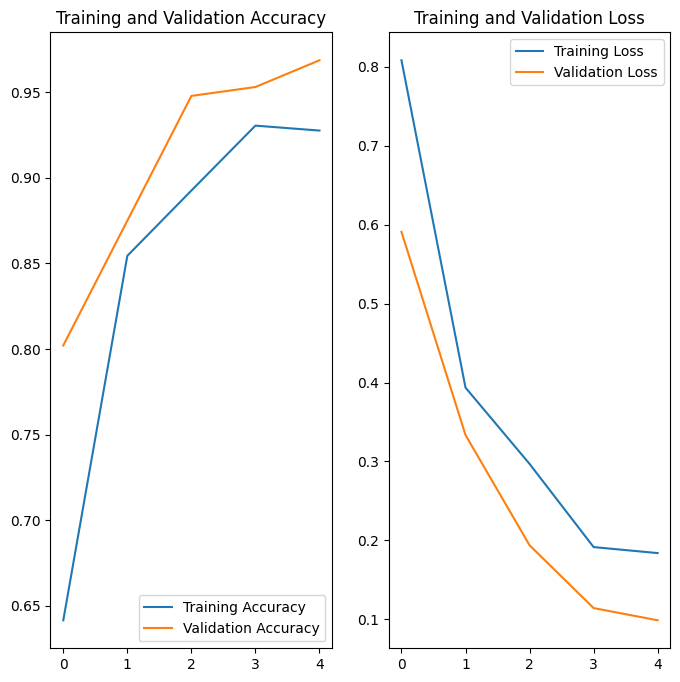

In [31]:
EPOCHS=5
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 285ms/step
predicted label: Potato___Early_blight


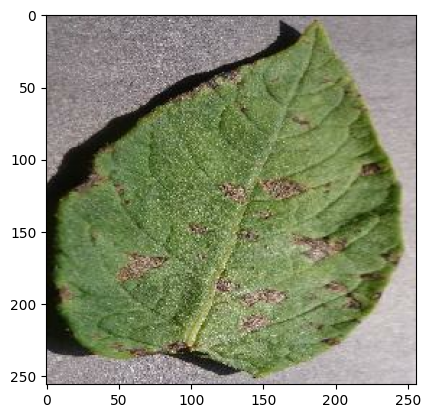

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


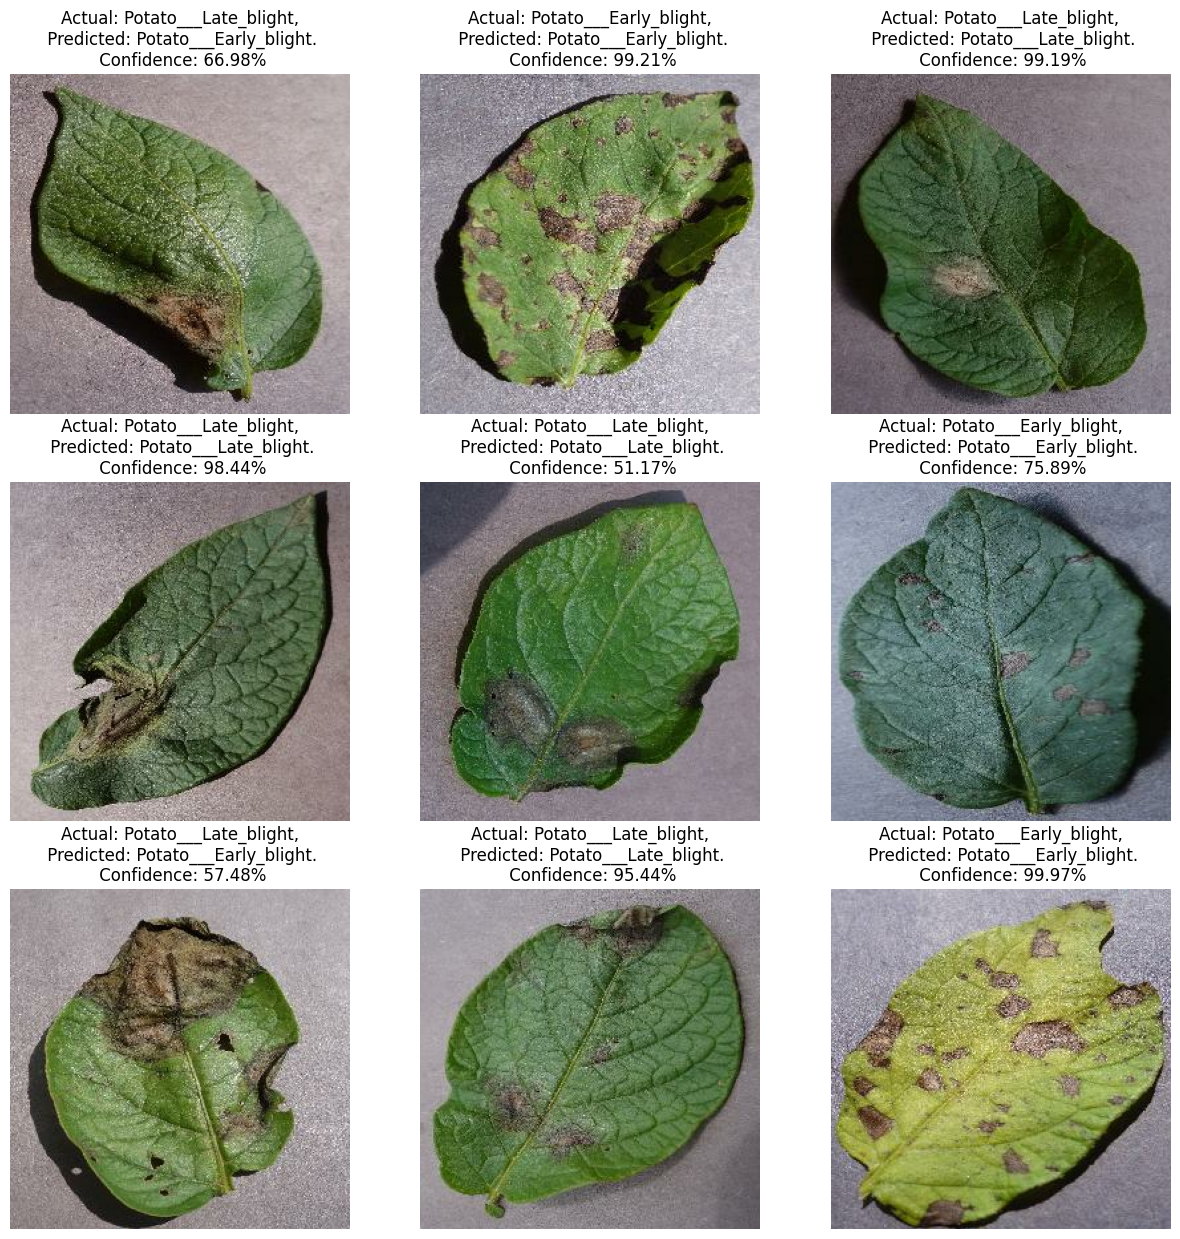

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
import os
import tensorflow as tf

# Define the model directory path
model_dir = "../saved_models"  # Ensure this is a folder, not a file
os.makedirs(model_dir, exist_ok=True)  # Create folder if it doesn't exist

# Determine the next model version by checking existing `.keras` files
existing_versions = [
    int(f.split(".")[0]) for f in os.listdir(model_dir) if f.endswith(".keras") and f.split(".")[0].isdigit()
]
model_version = max(existing_versions, default=0) + 1  # Increment version number

# Save the model in `.keras` format
model_path = f"{model_dir}/{model_version}.keras"
model.save(model_path, save_format="keras")  # Explicitly set the format

print(f"✅ Model saved at: {model_path}")


✅ Model saved at: ../saved_models/4.keras
